In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing

from collections import Counter

Load data

In [3]:
data = np.load('/content/flatland_train.npz')
X = data['X']
y = data['y']

Let's check the shape

In [4]:
X.shape

(10000, 50, 50)

In [5]:
y.shape

(10000,)

Change the numeration

In [6]:
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

Let's use the counter command

In [ ]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

We can see that a Hexagon is the figure that has the most corners in here.

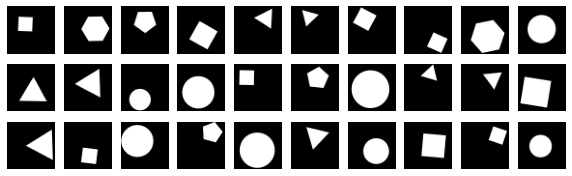

In [ ]:
plt.figure(figsize=(10, 3)) #plot of first 30 figures
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

Let's split data to training and testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

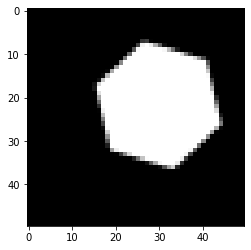

In [ ]:
plt.imshow(X_train[5], cmap='gray')

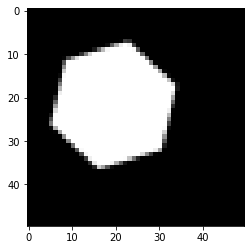

In [ ]:
plt.imshow(X_train[5][..., ::-1], cmap='gray')

In [ ]:
Counter(y_train)

Counter({3.0: 1617, 1.0: 2147, 0.0: 1002, 4.0: 1340, 2.0: 1394})

In [ ]:
Counter(y_test)

Counter({1.0: 706, 0.0: 379, 4.0: 421, 3.0: 520, 2.0: 474})

In [ ]:
X_train.shape

(7500, 50, 50, 1)

We will add one dimension for conv2D

In [8]:
X_train = X_train.reshape(X_train.shape[0], 50, 50, 1)
X_test = X_test.reshape(X_test.shape[0], 50, 50, 1)

We will use ImageDataGenerator to augment data.

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


datagen.fit(X_train)

In [11]:
len(X_train)

7500

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 32)        18464     
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 42, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                           

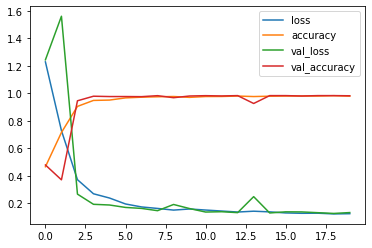

In [15]:
inp = keras.layers.Input(shape=(50, 50, 1))

out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(inp)
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out)
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(out)
out = keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(out)
out = keras.layers.MaxPool2D(pool_size=(3, 3))(out)

out = keras.layers.BatchNormalization(axis=-1)(out)

out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(out)
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(out)
out = keras.layers.MaxPool2D(pool_size=(2, 2))(out)

out = keras.layers.Flatten()(out)
out = keras.layers.Dense(512,  activation='relu')(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(216,  activation='relu')(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(5,  activation='softmax')(out)


model = keras.models.Model(inputs=inp, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                 validation_data=(X_test, y_test),
                 steps_per_epoch=len(X_train) / 32, epochs=20)



#hist = model.fit(X_train, y_train,
#                validation_data=(X_test, y_test),
#                 epochs=20, batch_size=128)

pd.DataFrame(hist.history).plot()

Now let's see the results

79/79 [==============================] - 1s 5ms/step


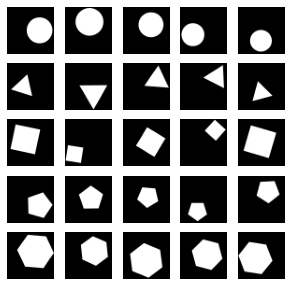

In [ ]:
pred = model.predict(X_test).argmax(axis=1)

X_test = X_test.reshape(X_test.shape[0], 50, 50)

plt.figure(figsize=(5, 5))
for label in range(5):
    for i in range(5):
        plt.subplot(5, 5, label * 5 + i +1)
        plt.imshow(X_test[pred == label][i], cmap='gray')
        plt.axis('off')
plt.show()

issaugoti modeli, atsisiusti notebooka...

In [17]:
model.save('CNN_augmented_data.h5')